In [1]:
#%pip install ltspice

In [19]:
import subprocess
from ltspice import Ltspice
import matplotlib.pyplot as plt
import numpy as np

In [20]:
48**2/1200
# P = V**2/R
P=1200 # 50
V= 48
R= V**2/P
R

1.92

In [21]:
txt = """
.param Freq=96k 
*.param Freq=61k
.param Vdc=380 
.param Cr=1.162090e-07 
.param Lr=2.179700e-05
.param Lm=6.539200e-05 
.param n=4 Ls={Lm/(n*n)} 
.param Co=3m
*.param Pnom=1200 
*.param Vnom=48 
*.param Rload={(Vnom*Vnom)/Pnom}
.param Rload=1.92
.param Ts={0.01/Freq}
.param Tsim={1000/Freq}
.param Tsave={995/Freq}
"""
with open("run/params2.txt", "w") as f:
    f.write(txt)

In [22]:
Lr= 2.179700e-05
Lm= 6.539200e-05 
Cr=1.162090e-07 
N = 4
Co=1e-3
Ls = Lm/(N*N)
Freq =100e3
Ts=0.01/Freq
Tsim = 1000/Freq
Tsave = 995/Freq
Ls

4.087e-06

In [23]:
R

1.92

In [24]:
txt = f"""
.param Freq ={Freq}
.param Vdc=380 
.param Cr={Cr}
.param Lr={Lr}
.param Lm={Lm}
.param Ls={Ls} 
.param Co={Co}
.param Rload={R}
.param Ts={Ts}
.param Tsim={Tsim}
.param Tsave={Tsave}
"""
with open("run/params2.txt", "w") as f:
    f.write(txt)

In [25]:
%time 
subprocess.run([r"C:\Users\a037702\AppData\Local\Programs\ADI\LTspice\LTspice.exe",
                "-b", "run/Simple_simulationV3.asc"])

CPU times: total: 0 ns
Wall time: 418 μs


CompletedProcess(args=['C:\\Users\\a037702\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe', '-b', 'run/Simple_simulationV3.asc'], returncode=0)

In [26]:
l = Ltspice("run/Simple_simulationV3.raw")
l.parse()


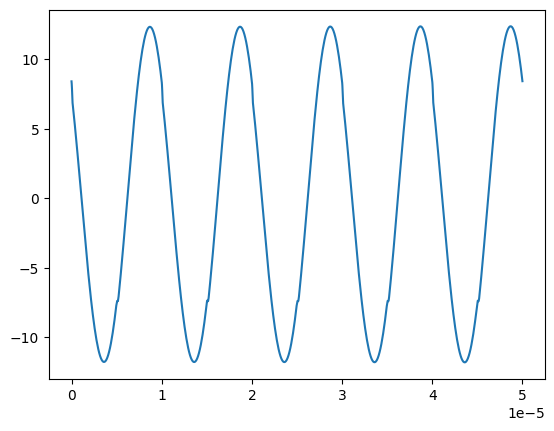

In [27]:
plt.plot(l.time, l.get_data("I(Lm)"))
plt.show()

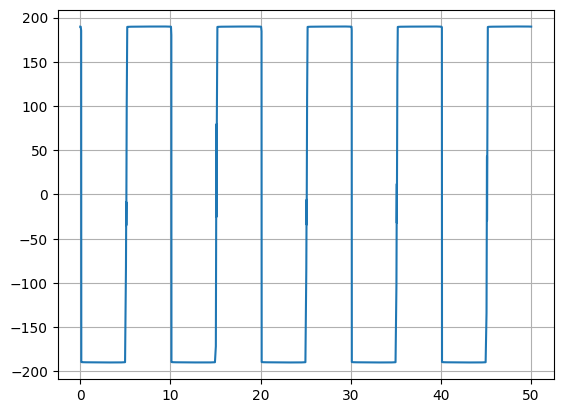

In [28]:
# vlm vm vlr
plt.plot(l.time*1e6, l.get_data("v(vlm)"))
plt.grid()
plt.show()

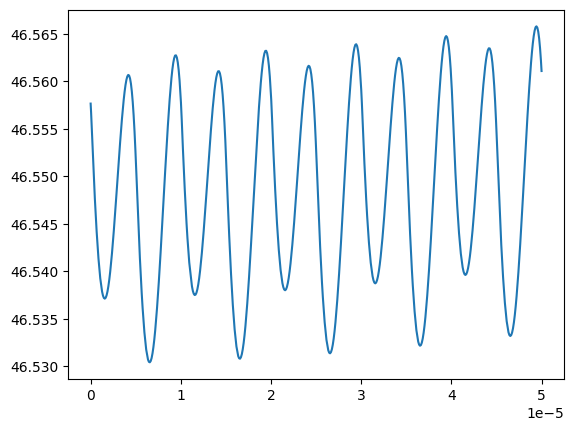

In [29]:
plt.plot(l.time, l.get_data("v(vout)"))
plt.show()

In [80]:
time = l.time
vlm = l.get_data("v(vlm)")
vlr = l.get_data("v(vlr)")-l.get_data("v(vlm)")
vcr = l.get_data("v(vm)")-l.get_data("v(vlr)")
im = l.get_data("I(Lm)")

In [14]:
from scipy.integrate import cumulative_trapezoid as trpz

-0.2177729243719976 0.2230475100116338
-0.2204102171918157 0.2204102171918157
-0.2204102171918157 0.2204102171918157


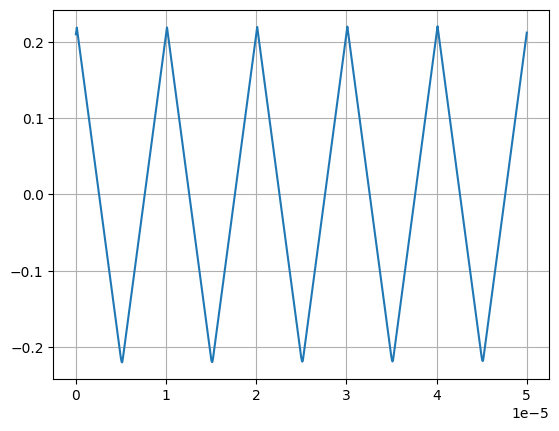

In [43]:
# V_Lm is square +/-200V 100khz DutyCycle=50% 5us, 5us
lambda_flux = trpz(y = vlm, x = time, initial = 0)
lambda_flux =lambda_flux  -np.mean(lambda_flux )
N = 4
flux = lambda_flux /N

# ELP 102/20/38 with I 102/7/38
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_102_20_38.pdf
Ae = 534.2 #mm2
Ae = Ae*1e-6

B = flux /Ae
print(B.min(), B.max())
# -0.21973865059485595 0.22249378320449606
#plt.plot(time, lambda_flux )
#plt.plot(time, flux)



Bpeakpeak= B.max()-B.min()
B= B-B.min()-Bpeakpeak/2
print(B.min(), B.max())
print(B.min(), B.max())

plt.plot(time, B)
plt.grid()
plt.show()

In [61]:
n= int(10e3 )
Ts = time .max()/n
time2 = np.arange(0, time .max(), Ts)

In [62]:
vcr2 = np.interp(xp= time, fp=vcr, x = time2) 
time2

array([0.0000e+00, 5.0000e-09, 1.0000e-08, ..., 4.9985e-05, 4.9990e-05,
       4.9995e-05], shape=(10000,))

-0.28749086515914385 0.3004578886928377
-0.29397437692599077 0.29397437692599077
-0.29397437692599077 0.29397437692599077


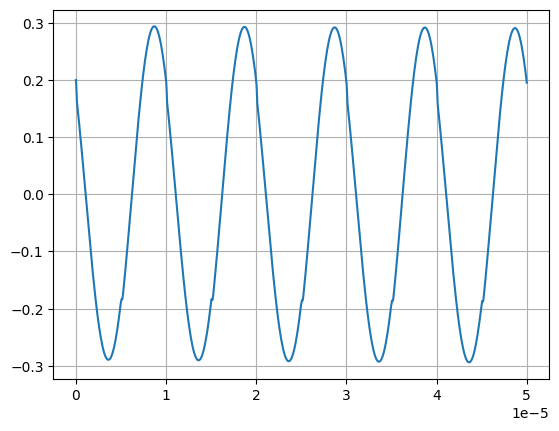

In [63]:
# V_Lm is square +/-200V 100khz DutyCycle=50% 5us, 5us
lambda_flux = trpz(y = vlr, x = time, initial = 0)
lambda_flux =lambda_flux  -np.mean(lambda_flux )
N = 4
flux = lambda_flux /N

# ELP 43/10/28 with ELP 43/10/28
# https://product.tdk.com/system/files/dam/doc/product/ferrite/ferrite/ferrite-core/data_sheet/80/db/fer/elp_43_10_28.pdf
Ae = 225 #mm2
Ae = Ae*1e-6

B = flux /Ae
print(B.min(), B.max())
# -0.21973865059485595 0.22249378320449606
#plt.plot(time, lambda_flux )
#plt.plot(time, flux)


Bpeakpeak= B.max()-B.min()
B= B-B.min()-Bpeakpeak/2
print(B.min(), B.max())
print(B.min(), B.max())

plt.plot(time, B)
plt.grid()
plt.show()

np.float64(200000000.00000122)

In [76]:
# ic = Cr *dvcr/dt
# derivation is a bade idea 
import numpy as np
from scipy.signal import savgol_filter


def ic_from_vc_savgol(vc, fs, C, window_samples=101, polyorder=3):
    # ensure odd window
    if window_samples % 2 == 0:
        window_samples += 1

    # limit to signal length
    if window_samples > len(vc):
        window_samples = len(vc) - 1 - (len(vc)-1) % 2

    dvc_dt = savgol_filter(vc,
                           window_length=window_samples,
                           polyorder=polyorder,
                           deriv=1,
                           delta=1/fs,
                           mode='interp')

    return C * dvc_dt
ic = ic_from_vc_savgol(vcr2, fs=1/Ts, C=Cr, window_samples=101)


In [82]:
import numpy as np


fs = 1/Ts # sampling frequency (Hz)
dt = Ts


# derivative
dvc_dt = np.diff(vcr2) / dt

# capacitor current
icdrv = Cr * dvc_dt


In [87]:
icdrv.shape, time2.shape

((9999,), (10000,))

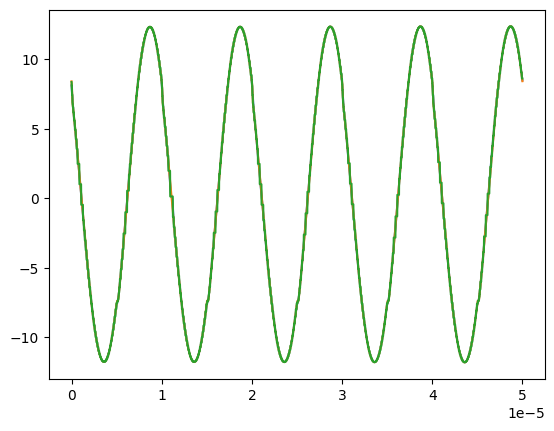

In [89]:
plt.plot(time2, ic)
plt.plot(time, im)
plt.plot(time2[:-1], icdrv)